# Stimulator 

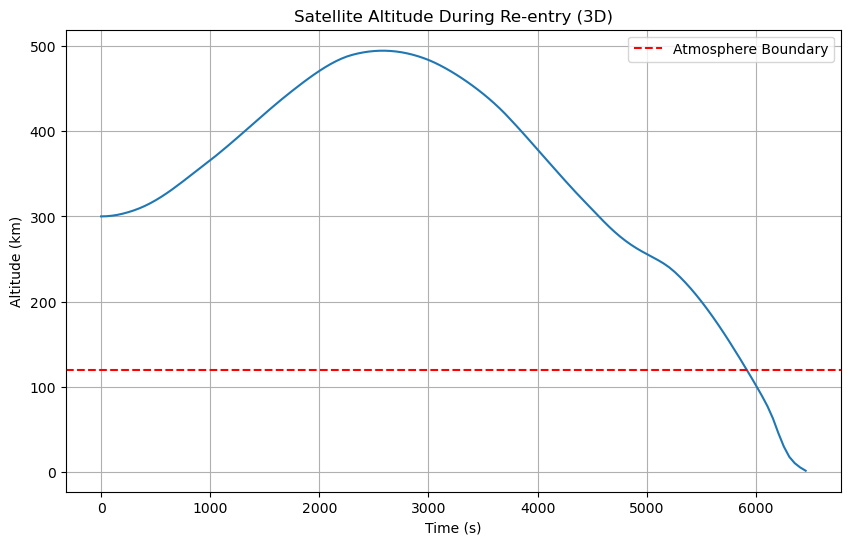

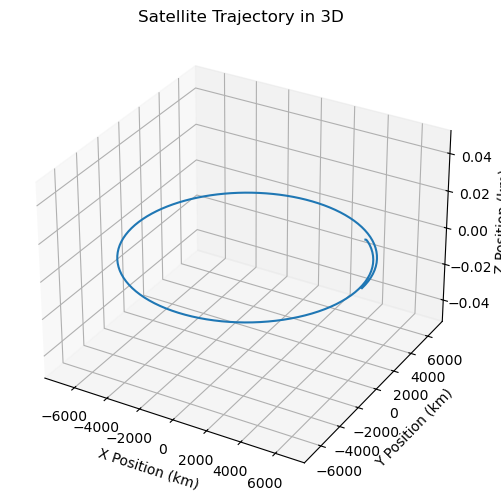

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24  # Mass of Earth (kg)
R_EARTH = 6371e3  # Radius of Earth (m)
ATMOSPHERE_HEIGHT = 120e3  # Approximate height of the atmosphere (m)
CD = 2.2  # Drag coefficient (dimensionless)
A = 1.0  # Cross-sectional area of the satellite (m^2)
M_SAT = 500  # Mass of the satellite (kg)
RHO_0 = 1.225  # Air density at sea level (kg/m^3)
H_SCALE = 8500  # Scale height of the atmosphere (m)

# Function to calculate atmospheric density
def atmospheric_density(altitude):
    if altitude > 0:
        return RHO_0 * np.exp(-altitude / H_SCALE)
    else:
        return 0

# Diff. eqns for satellite motion
def satellite_dynamics(t, y):
    x, y_pos, z, vx, vy, vz = y
    r = np.sqrt(x**2 + y_pos**2 + z**2)
    altitude = r - R_EARTH

    # Gravity
    F_gravity = -G * M_EARTH / r**2

    # Drag
    rho = atmospheric_density(altitude)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
    F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
    F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT

    # Acceleration
    ax = F_gravity * (x / r) + F_drag_x
    ay = F_gravity * (y_pos / r) + F_drag_y
    az = F_gravity * (z / r) + F_drag_z

    return [vx, vy, vz, ax, ay, az]

def stop_condition(t, y):
    # Stop when altitude <= 0
    r = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)
    altitude = r - R_EARTH
    return altitude

# Solves diff. eqn system between measurements radar(n) and radar(n+1)
def system_solver(t_span, initial_conditions, t_evals=1000):
    t_eval = np.linspace(t_span[0], t_span[1], t_evals)
    
    stop_condition.terminal = True
    stop_condition.direction = -1
    
    # Solve the system of equations using RK45
    solution = solve_ivp(satellite_dynamics, t_span, initial_conditions, method='RK45', t_eval=t_eval, events=stop_condition)
    return solution

# ----------------------------- TESTING -----------------------------
# Testing the satellite dynamics to make sure it works correctly, just use the above functions to get radar measurements

# Initial conditions
altitude_initial = 300e3
velocity_initial = 7800
x0 = R_EARTH + altitude_initial
y0 = 0
z0 = 0
vx0 = 0
vy0 = velocity_initial
vz0 = 0
initial_conditions = [x0, y0, z0, vx0, vy0, vz0]

# Time span
t_span = (0, 50000)
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points for evaluation

# Solve differential equations using RK45
solution = system_solver(t_span, initial_conditions, t_evals=1000)

x_vals = solution.y[0]
y_vals = solution.y[1]
z_vals = solution.y[2]
altitudes = np.sqrt(x_vals**2 + y_vals**2 + z_vals**2) - R_EARTH

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(solution.t, altitudes / 1e3)  # Altitude vs. time
plt.axhline(ATMOSPHERE_HEIGHT / 1e3, color='r', linestyle='--', label='Atmosphere Boundary')
plt.title('Satellite Altitude During Re-entry (3D)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.legend()
plt.grid()
plt.show()

# 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_vals / 1e3, y_vals / 1e3, z_vals / 1e3)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
plt.show()

# Uncented Kalman Filter

### 1. Prediction step

In [3]:
def f(state, dt):
    """
    Propagates the satellite state forward in time by dt seconds,
    considering gravity and atmospheric drag.

    Parameters:
        state (np.ndarray): (6, 1) array [x, y, z, vx, vy, vz]
        dt (float): time step in seconds

    Returns:
        np.ndarray: (6, 1) updated state after dt seconds
    """

    # Unpack state vector
    x, y, z, vx, vy, vz = state.flatten()

    # Calculate distance from center of Earth
    r = np.sqrt(x**2 + y**2 + z**2)
    altitude = r - R_EARTH

    # Calculate gravitational force
    F_gravity = -G * M_EARTH / r**2

    # Calculate atmospheric drag force
    rho = atmospheric_density(r - R_EARTH)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
    F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
    F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT

    # Update velocities
    ax = F_gravity * (x / r) + F_drag_x
    ay = F_gravity * (y / r) + F_drag_y
    az = F_gravity * (z / r) + F_drag_z

    # Update positions using Euler's method
    x_new = x + vx * dt
    y_new = y + vy * dt
    z_new = z + vz * dt

    # Update velocities using Euler's method
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt

    return np.array([[x_new], [y_new], [z_new], [vx_new], [vy_new], [vz_new]])

def propagate_sigma_points(sigma_points, dt):
    """
    Applies the motion model f to each sigma point.

    Parameters:
        sigma_points (np.ndarray): shape (6, 2n+1), each column is a sigma point
        dt (float): time step

    Returns:
        np.ndarray: propagated sigma points, shape (6, 2n+1)
    """
    n, num_sigma = sigma_points.shape
    propagated = np.zeros_like(sigma_points)

    for i in range(num_sigma):
        xi = sigma_points[:, i].reshape(n, 1)  # (6, 1)
        propagated[:, i] = f(xi, dt).flatten()

    return propagated

### 2. Measurment prediction

### 3. Update step